# Analysis and prediction of total geographical land use

<!-- <center><img src= "https://www.newfoodmagazine.com/wp-content/uploads/shutterstock_1118643128-scaled.jpg" alt ="crops" style="width:400px;"></center><br> -->

<!-- - Machine Learning has the capability to effectively analyze soil data, such as moisture level, temperature, and chemical composition, which have a significant impact on the growth of crops and the health of livestock.

- In the field of agriculture, this technology allows for precise cultivation of crops, where each plant and animal can be treated individually, leading to more effective decisions by farmers.

- By leveraging Machine Learning, it is possible to develop methods to predict crop yields and assess the quality of crops on a per-species basis, thus making it possible to detect crop diseases and weed infestations which were previously impossible. -->

In [136]:
# Disable warnings

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)


In [137]:
# Importing the neccessary libraries

import numpy as np
import pandas as pd


# Ensemble learning on the Kaggle dataset

Dataset taken from Kaggle, present [here](./datasets/Crop_recommendation.csv)

In [138]:
# Reading the dataset
df = pd.read_csv("./datasets/crop_recommendation.csv")


In [139]:
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [140]:
df.describe()


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


Colnames is the name of all columns in the datset

In [141]:
colnames = list(df.columns)
rownums = len(df[colnames[0]])


In [142]:
print("Columns in the dataset are", ", ".join(colnames))
print("The number of rows is",rownums)


Columns in the dataset are N, P, K, temperature, humidity, ph, rainfall, label
The number of rows is 2200


Let us create separate test and training dataframes from the total dataset. We shuffle the rows first since it is ordered by crops, and we want to include all crops in training.

Training dataset = First 2000 rows
Testing dataset = 200 rows after that

In [143]:
df = df.sample(frac=1).reset_index(drop=True)

size_of_training = rownums - rownums // 10

print(
    f"Length of training dataset is {size_of_training}, length of testing is {rownums - size_of_training}"
)

training_df = df.iloc[:size_of_training, :]
testing_df = df.iloc[size_of_training:, :]


Length of training dataset is 1980, length of testing is 220


In [144]:
training_df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,108,23,51,26.843661,83.850400,6.106501,40.228644,watermelon
1,91,24,55,26.270616,83.091945,6.259087,46.768375,watermelon
2,11,36,31,27.920633,51.779659,6.475449,100.258567,mango
3,113,15,29,27.096172,63.553243,6.779230,190.244057,coffee
4,9,49,16,30.884827,41.365618,7.661537,55.053805,mothbeans


In [145]:
feature_variables = colnames.copy()
feature_variables.remove("label")

target_labels = list(set(training_df["label"]))

print("Feature variables are", ", ".join(feature_variables))
print("Target labels are ", ", ".join(target_labels))


Feature variables are N, P, K, temperature, humidity, ph, rainfall
Target labels are  watermelon, mothbeans, papaya, mungbean, mango, banana, orange, chickpea, coffee, kidneybeans, grapes, apple, pomegranate, jute, coconut, rice, pigeonpeas, lentil, muskmelon, maize, cotton, blackgram


Feature variables are everything except the name of the crops

Feature matrix is the values of all the feature variables in a matrix format

In [146]:
feature_matrix = []

for i in range(len(training_df[colnames[0]])):
    _ = []

    for feature_variable in feature_variables:
        _str = training_df.at[i, feature_variable]

        val = int(_str) if int(_str) == float(_str) else float(_str)

        _.append(val)
    feature_matrix.append(_)


In [147]:
target_matrix = [
    training_df.at[i, "label"] for i in range(len(training_df[colnames[0]]))
]


In [148]:
print(
    "Feature & target matrix:",
    f"{feature_matrix[0]} {target_matrix[0]}",
    f"{feature_matrix[1]} {target_matrix[1]}",
    f"{feature_matrix[2]} {target_matrix[2]}",
    f"{feature_matrix[3]} {target_matrix[3]}",
    f"{feature_matrix[4]} {target_matrix[4]}",
    "and so on",
    sep="\n",
)


Feature & target matrix:
[108, 23, 51, 26.84366082, 83.85039964, 6.106500787000001, 40.228644] watermelon
[91, 24, 55, 26.27061608, 83.09194521, 6.259086582999999, 46.76837499] watermelon
[11, 36, 31, 27.92063282, 51.77965917, 6.47544932, 100.2585673] mango
[113, 15, 29, 27.09617155, 63.55324262, 6.779230041, 190.2440566] coffee
[9, 49, 16, 30.88482722, 41.36561835, 7.661537347999999, 55.053805] mothbeans
and so on


In [149]:
# Modules for making a Voter
from sklearn.ensemble import VotingClassifier as Voter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [150]:
# Using X,Y naming convention as input output
X = feature_matrix
Y = target_matrix

# Base classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = LogisticRegression(random_state=1)


In [151]:
# Voting classifier
ensemble_clf = Voter(
    estimators=[("dt", clf1), ("rf", clf2), ("lr", clf3)], voting="hard"
)

# Fitting your voting classifier to the data (feature_matrix and target_matrix)
ensemble_clf.fit(X, Y)


VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=4)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('lr', LogisticRegression(random_state=1))])

In [152]:
print(
    ensemble_clf.predict(
        [[60, 42, 23, 19.32666088, 68.03449300000001, 6.192360002999999, 84.22969177]]
    )
)


['maize']


## Checking accuracy of model using testing dataset (200 rows) after building the ensemble voter on training dataset (2000 rows)

In [153]:
testing_df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
1980,31,20,26,25.565678,97.613615,6.443169,199.793634,coconut
1981,9,25,41,24.815301,91.908430,5.972715,109.285342,pomegranate
1982,4,20,41,24.266013,93.797406,6.537043,104.537511,pomegranate
1983,82,77,46,28.947047,82.188900,5.901101,95.830164,banana
1984,131,52,16,23.657241,84.476015,6.486068,88.544791,cotton


In [154]:
testing_df_matrix = []


for i in range(len(testing_df[colnames[0]])):
    _ = []

    for feature_variable in feature_variables:
        _str = testing_df.at[size_of_training + i, feature_variable]

        val = int(_str) if int(_str) == float(_str) else float(_str)

        _.append(val)
    testing_df_matrix.append(_)

In [155]:
prediction_output = ensemble_clf.predict(testing_df_matrix)
count = 0
for i, output in enumerate(prediction_output):
    if output == testing_df.at[size_of_training + i, "label"]:
        count += 1
print(f"Accuracy is {round((count/(rownums - size_of_training))*100,3)}%")


Accuracy is 98.182%


# Exploratory Data Analysis and Data Visualisation

In [129]:
# Necessary libraries for visualisation

import seaborn
import matplotlib.pyplot
%matplotlib inline

We can use a heatmap to check null/missing values

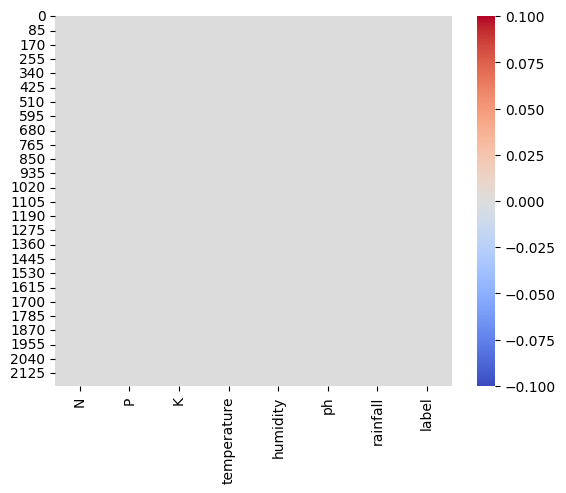

In [130]:
seaborn.heatmap(df.isnull(), cmap="coolwarm")
matplotlib.pyplot.show()


Let's have a closer look at the distribution of temperature and ph.
    
It is symmetrical and bell shaped, showing that trials will usually give a result near the average, but will occasionally deviate by large amounts. It's also fascinating how these two really resemble each other!

<Axes: xlabel='ph', ylabel='Density'>

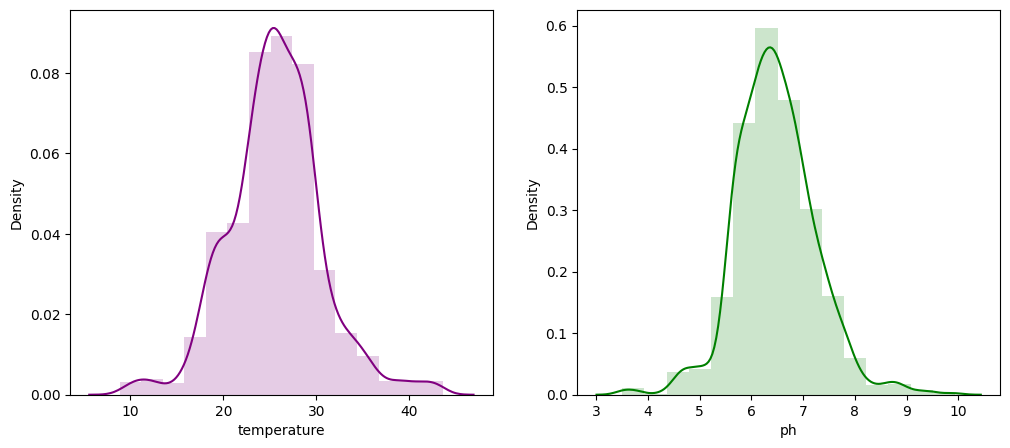

In [131]:
matplotlib.pyplot.figure(figsize=(12, 5))

matplotlib.pyplot.subplot(1, 2, 1)
# seaborn.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})

seaborn.distplot(df["temperature"], color="purple", bins=15, hist_kws={"alpha": 0.2})

matplotlib.pyplot.subplot(1, 2, 2)
seaborn.distplot(df["ph"], color="green", bins=15, hist_kws={"alpha": 0.2})


A quick check if the dataset is balanced or not.

If it is imbalanced, we will need to  downsample targets which are more frequent.

<Axes: xlabel='count', ylabel='label'>

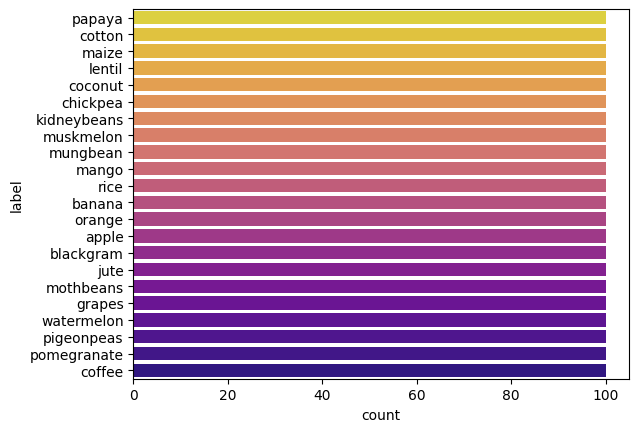

In [132]:
seaborn.countplot(y="label", data=df, palette="plasma_r")


There does not seem to be an imbalance.

### Master plot to visualize the diagonal distribution between two features for all the combinations!

It is useful to help see how classes differ from each other in a particular space.

In [133]:
seaborn.pairplot(df, hue="label")


Error in callback <function _draw_all_if_interactive at 0x000002792D156980> (for post_execute):


KeyboardInterrupt: 

When it rains, average rainfall is high  and temperature is mildly chill (less than 30'C).

Rain affects soil moisture which affects ph of the soil. Here are the crops which are likely to be planted during this season.

Rice needs <b> heavy rainfall (>200 mm)</b> and a <b>humidity above 80%</b>.

Coconut is a tropical crop. It needs high humidity therefore explaining massive exports from areas like Kerala and Tamil Nadu, which are few coastal areas around the country.

In [ ]:
seaborn.jointplot(
    x="rainfall",
    y="humidity",
    data=df[(df["temperature"] < 30) & (df["rainfall"] > 120)],
    hue="label",
)


This graph shows average values of both potassium (K) and nitrogen (N) (>50).

Fruits which have high nutrients typically has consistent potassium values.

In [ ]:
seaborn.jointplot(x="K", y="N", data=df[(df["N"] > 40) & (df["K"] > 40)], hue="label")


Pairplot between `humidity` and `K` (potassium levels in the soil.)

Using `seaborn.jointplot()` for bivariate analysis, we plot `humidity` and `K` levels based on Label type.

It further generates frequency distribution of classes with respect to features

In [ ]:
seaborn.jointplot(x="K", y="humidity", data=df, hue="label", size=8, s=30, alpha=0.7)


In [ ]:
seaborn.boxplot(y="label", x="ph", data=df)


As visible, `ph` values are critical when it comes to soil. A stability between 6 and 7 is preffered

In [ ]:
seaborn.boxplot(y="label", x="P", data=df[df["rainfall"] > 150])


One thing we found during our exploratory analysis stage is that the Phosphorous (`P`) levels are quite differentiable when it rains heavily (above 150 mm).

#### Further analyzing phosphorous levels.

When humidity is less than 65, almost same phosphor levels(approx 14 to 25) are required for 6 crops which could be grown just based on the amount of rain expected over the next few weeks.

In [ ]:
seaborn.lineplot(data=df[(df["humidity"] < 65)], x="K", y="rainfall", hue="label")


# Pre-processing for ML Model

In [ ]:
c = df.label.astype("category")
targets = dict(enumerate(c.cat.categories))
df["target"] = c.cat.codes

y = df.target
X = df[["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]]


**Correlation visualization between features. We can see how Phosphorous levels and Potassium levels are highly correlated.**

In [ ]:
seaborn.heatmap(X.corr())


# FEATURE SCALING
**Feature scaling is required before creating training data and feeding it to the model.**

As we saw earlier, two of our features (temperature and ph) are gaussian distributed, therefore scaling them between 0 and 1 with MinMaxScaler.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)


# MODEL SELECTION

## KNN Classifier for Crop prediction. 
<hr>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
seaborn.set(font_scale=1.0)  # for label size
matplotlib.pyplot.figure(figsize=(12, 8))
seaborn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="terrain")


### Let's try different values of n_neighbors to fine tune and get better results

In [ ]:
k_range = range(1, 11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

matplotlib.pyplot.xlabel("k")
matplotlib.pyplot.ylabel("accuracy")
matplotlib.pyplot.scatter(k_range, scores)
matplotlib.pyplot.vlines(k_range, 0, scores, linestyle="dashed")
matplotlib.pyplot.ylim(0.96, 0.99)
matplotlib.pyplot.xticks([i for i in range(1, 11)])


## Classification using Support Vector Classifer (SVC)
<hr>

In [ ]:
from sklearn.svm import SVC as SupportVectorClassifier

svc_poly = SupportVectorClassifier(kernel="rbf").fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy: ", svc_poly.score(X_test_scaled, y_test))

svc_linear = SupportVectorClassifier(kernel="linear").fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy: ", svc_linear.score(X_test_scaled, y_test))

svc_poly = SupportVectorClassifier(kernel="poly").fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy: ", svc_poly.score(X_test_scaled, y_test))


In [ ]:
# Increase the accuracy by parameter tuning.


from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {
    "C": np.logspace(-3, 2, 6).tolist(),
    "gamma": np.logspace(-3, 2, 6).tolist(),
}
# 'degree': np.arange(0,5,1).tolist(), 'kernel':['linear','rbf','poly']

model = GridSearchCV(
    estimator=SupportVectorClassifier(kernel="linear"),
    param_grid=parameters,
    n_jobs=-1,
    cv=4,
)
model.fit(X_train, y_train)


In [ ]:
print(model.best_score_)
print(model.best_params_)


- Liner kernel seems to be giving satisfactory results, but using fine tuning increases the computation.
- The accuracy can be increased in poly-kernel by tweaking parameters, but it leads to intensive overfitting.
- RBF > linear kernel result wise.
- Best kernel - <b>Poly kernel</b> (by a small margin).

## Classifying using decision tree
<hr>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)


### Let's visualize the import features which are taken into consideration by decision trees.

In [ ]:
matplotlib.pyplot.figure(figsize=(10, 4), dpi=80)
c_features = len(X_train.columns)
matplotlib.pyplot.barh(range(c_features), clf.feature_importances_)
matplotlib.pyplot.xlabel("Feature importance")
matplotlib.pyplot.ylabel("Feature name")
matplotlib.pyplot.yticks(np.arange(c_features), X_train.columns)
matplotlib.pyplot.show()


## Classification using Random Forest.
<hr>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42).fit(
    X_train, y_train
)

print("RF Accuracy on training set: {:.2f}".format(clf.score(X_train, y_train)))
print("RF Accuracy on test set: {:.2f}".format(clf.score(X_test, y_test)))


#### Classification

Let's use `yellowbrick` for classification report. It is great for visualizing in a tabular format.

In [ ]:
from yellowbrick.classifier import ClassificationReport

classes = list(targets.values())
visualizer = ClassificationReport(clf, classes=classes, support=True, cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()


## Classification using Gradient Boosting
<hr>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

grad = GradientBoostingClassifier().fit(X_train, y_train)
print("Gradient Boosting accuracy : {}".format(grad.score(X_test, y_test)))
